In [1]:
from related_generator.post import Post
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import umap
from pathlib import Path
from tqdm.notebook import trange, tqdm
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
# from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor
import time

nltk.download("punkt")
%matplotlib widget

[nltk_data] Downloading package punkt to /home/wint3rmute/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
import math
import markdown
import subprocess
from dataclasses import dataclass, field
from pathlib import Path

from bs4 import BeautifulSoup
from typing import Optional


@dataclass
class Post:
    title: str
    content: str
    path: Path

    related_links: list[str]
    
    # To be filled by map generation
    x: float = 0.0
    y: float = 0.0

    @classmethod
    def from_path(cls, path: Path):
        content_raw = path.read_text()
        html_tree = BeautifulSoup(content_raw, features="html.parser")
        
        # Get links from <nav>
        content_raw = path.read_text()
        html_tree = BeautifulSoup(content_raw, features="html.parser")
        nav_links = [l.attrs["href"] for l in html_tree.nav.find_all("a")]
        
        # Important: nav + footer MUST BE removed for later processing stages
        html_tree.nav.decompose()
        html_tree.footer.decompose()
        
        # Get 'Incoming' links
        incoming_links = cls.find_incoming_links(path, html_tree) or []
        
        content = html_tree.text.replace("\n", "")
        title = path.name

        to_trim = content.rfind("Incoming:")
        if to_trim != -1:
            content = content[to_trim:]
       
        related_links = list(set(nav_links) | set(incoming_links))
        return cls(title=title, content=content, path=path, related_links=related_links)
    
    @staticmethod
    def find_incoming_links(path, html_tree) -> Optional[list]:
        all_links = html_tree.find_all("a")[::-1]
        incoming_links = []
        for link in all_links:
            try:
                incoming_links.append(link.attrs["href"])
            except Exception as e:
                if link.text != "link" and link.text != "external link" and link.text != "local link":
                    raise ValueError(link)
                    raise e
            
            if "class" in link.attrs:
                return incoming_links

        # Executed if the links structure is atypical
        return None
    

    def distance_to(self, post: "Post") -> float:
        return math.sqrt((self.x - post.x) ** 2 + (self.y - post.y) ** 2)


def get_all_posts_oscean() -> list[Post]:
    all_posts_paths = Path.glob(Path("/home/wint3rmute/code/misc/oscean/site/"), "**/*.html")
    all_posts_paths = [path for path in all_posts_paths]

    with ThreadPoolExecutor() as p:
        all_posts = list(tqdm(p.map(Post.from_path, all_posts_paths), total=len(all_posts_paths)))
        return all_posts

all_posts = get_all_posts_oscean()

  0%|          | 0/462 [00:00<?, ?it/s]

In [22]:
def custom_tokenizer(text: str) -> list[str]:
    stemmer = SnowballStemmer("english")
    words = word_tokenize(text) 
    
    return [stemmer.stem(word) for word in words]

In [33]:

# Vectorizer to convert a collection of raw documents to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)

# Learn vocabulary and idf, return term-document matrix.
tfidf = vectorizer.fit_transform([post.content for post in all_posts])

# umap_result = umap.UMAP().fit_transform(
#     tfidf
# )

In [31]:
sorted(list(vectorizer.vocabulary_.keys()))[:10]
# tfidf

['!', '#', '$', '%', '&', "'", "''", "'d", "'m", "'n"]

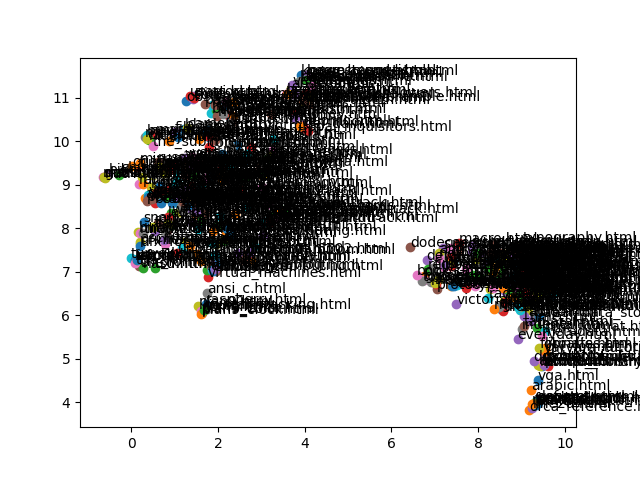

In [25]:
plt.close()

from itertools import count
import random
# index = count()
for post, post_position, post_index in zip(all_posts, umap_result, count()):
    plt.scatter(post_position[0], post_position[1])
    
    # if random.choice([1,2]) == 1:
    plt.annotate(post.title, post_position, post_position)

plt.show()